<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Quickstart (Simulation with TensorFlow/Keras)

Welcome to Flower, a friendly federated learning framework!

In this notebook, we'll simulate a federated learning system with 100 clients. The clients will use TensorFlow/Keras to define model training and evaluation. Let's start by installing Flower (published as `flwr` on PyPI) with the `simulation` extra:

In [101]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]

Let's also install Matplotlib so we can make some plots once the simulation is completed

In [102]:
!pip install matplotlib

Next, we import the required dependencies. The most important imports are Flower (`flwr`) and TensorFlow:

In [103]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

from datasets import Dataset
from flwr_datasets import FederatedDataset

VERBOSE = 0
NUM_CLIENTS = 100

In [104]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

##Get the data: preprocessing
First download and import the dataset using pandas:

In [106]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/gpu_anastasia", download_mode="force_redownload")

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Generating train split:   0%|          | 0/193280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/48320 [00:00<?, ? examples/s]

Train dataset size: 193280
Test dataset size: 48320


In [107]:
raw_df = pd.DataFrame(dataset['train'])
raw_columns = list(dataset['train'].features.keys())
raw_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),avg_runs
0,135475,64,128,32,16,16,8,16,8,2,2,0,0,1,1,39.74,39.73,39.71,39.73,39.7275
1,30555,32,32,32,16,16,16,8,8,2,2,1,0,1,1,37.04,36.89,36.24,36.82,36.7475
2,37111,32,64,16,16,16,16,16,8,1,2,0,1,1,1,32.81,32.89,32.63,32.75,32.7700
3,223611,128,128,32,8,16,32,8,2,2,8,1,0,1,1,919.07,886.25,886.06,886.48,894.4650
4,123017,64,128,16,32,16,32,32,8,1,4,1,0,0,1,30.78,30.76,30.77,30.78,30.7725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193275,59158,32,128,32,8,32,8,16,2,2,4,0,1,1,0,22.24,21.95,22.15,23.00,22.3350
193276,150875,128,32,16,8,8,16,16,2,8,2,1,0,1,1,161.07,161.26,161.10,161.25,161.1700
193277,127702,64,128,32,8,16,16,8,2,1,8,0,1,1,0,178.02,176.55,175.63,176.74,176.7350
193278,464,16,16,16,8,16,16,16,8,1,1,0,0,0,0,135.54,135.57,135.30,135.33,135.4350


### Clean the data

The dataset does not contain unknown values.

The `"Unnamed: 0"` column is just an id, not relevant for our goals, so we are just going to ignore it.

Here follows an explanation for the other features, (found at https://archive.ics.uci.edu/dataset/440/sgemm+gpu+kernel+performance):

- 1-2. MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer);
- 3.  KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer);
- 4-5. MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer);
- 6-7. MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer);
- 8. KWI: kernel loop unrolling factor: {2, 8} (integer);
- 9-10. VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer);
- 11-12. STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical);
- 13-14. SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical).

The columns Run1, Run2, Run3, Run4 measure the performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.
The last column 'avg_runs' just averages over the 4 total runs.


There is no need to process the dataset further because the categorical features are already one-hot encoded.

### Split the data into training and test sets

Moreover, the dataset was loaded onto the hugging hub already with a split into training set and test set (80%-20%).

In [108]:
train_dataset = raw_df.drop(axis=1, columns=['Unnamed: 0'])

test_dataset = pd.DataFrame(dataset['test']).drop(axis=1, columns=['Unnamed: 0'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Inspect the data

Review a few columns from the training set.. need to do some more research..

In [109]:
train_df = train_dataset.drop(axis=1, columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'])
test_df = test_dataset.drop(axis=1, columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'])
column_names = train_df.columns
train_df.head()
column_names

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'avg_runs'],
      dtype='object')

In [110]:
train_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(193280, 15)

In [111]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MWG,193280.0,80.453146,42.471526,16.0000,32.000000,64.00000,128.000000,128.0000
NWG,193280.0,80.369619,42.465333,16.0000,32.000000,64.00000,128.000000,128.0000
KWG,193280.0,25.514818,7.855294,16.0000,16.000000,32.00000,32.000000,32.0000
MDIMC,193280.0,13.935720,7.871337,8.0000,8.000000,8.00000,16.000000,32.0000
NDIMC,193280.0,13.955877,7.883382,8.0000,8.000000,8.00000,16.000000,32.0000
MDIMA,193280.0,17.375207,9.395169,8.0000,8.000000,16.00000,32.000000,32.0000
NDIMB,193280.0,17.374834,9.387766,8.0000,8.000000,16.00000,32.000000,32.0000
KWI,193280.0,4.997734,3.000007,2.0000,2.000000,2.00000,8.000000,8.0000
VWM,193280.0,2.449364,1.954978,1.0000,1.000000,2.00000,4.000000,8.0000
VWN,193280.0,2.447429,1.953661,1.0000,1.000000,2.00000,4.000000,8.0000


Let's start by defining the model we want to federated. Since we will be working with MNIST, using a fully connected model is sufficient. You can of course customize this model.

In [112]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_tr_scaled = scaler.fit_transform(train_df)
x_ts_scaled = scaler.transform(test_df)

print("Media distribuzione di partenza: {}".format(np.mean(train_df, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_tr_scaled, axis=0)))
print("Deviazione standard distribuzione di partenza: {}".format(np.std(train_df, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_tr_scaled, axis=0)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Media distribuzione di partenza: MWG          80.453146
NWG          80.369619
KWG          25.514818
MDIMC        13.935720
NDIMC        13.955877
MDIMA        17.375207
NDIMB        17.374834
KWI           4.997734
VWM           2.449364
VWN           2.447429
STRM          0.499772
STRN          0.499731
SA            0.499917
SB            0.500109
avg_runs    217.785314
dtype: float64
Media distribuzione scalata: [ 0.171  0.171 -0.405  0.742  0.744  0.057  0.057  0.5    0.15   0.149
  0.5    0.5    0.5   -0.5    0.79 ]
Deviazione standard distribuzione di partenza: MWG          42.471416
NWG          42.465223
KWG           7.855274
MDIMC         7.871316
NDIMC         7.883362
MDIMA         9.395144
NDIMB         9.387742
KWI           2.999999
VWM           1.954973
VWN           1.953656
STRM          0.500000
STRN          0.500000
SA            0.500000
SB            0.500000
avg_runs    369.961685
dtype: float64
Deviazione standard distribuzione scalata: [0.442 0.442 0.491 0

Once the dataset was cleaned and scaled/normalized it was moved back again to Hugging Face.

In [113]:
train = pd.DataFrame(x_tr_scaled, columns=column_names)
test = pd.DataFrame(x_ts_scaled, columns=column_names)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
train.to_csv('gpu_clean_train.csv')
test.to_csv('gpu_clean_test.csv')

### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [115]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('avg_runs')
test_labels = test_features.pop('avg_runs')

In [116]:
train_df.describe().transpose()[['mean', 'std']]

,mean,std
MWG,80.453146,42.471526
NWG,80.369619,42.465333
KWG,25.514818,7.855294
MDIMC,13.935720,7.871337
NDIMC,13.955877,7.883382
MDIMA,17.375207,9.395169
NDIMB,17.374834,9.387766
KWI,4.997734,3.000007
VWM,2.449364,1.954978
VWN,2.447429,1.953661


## Model

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer, then fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

In [117]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[80.453 80.37  25.515 13.936 13.956 17.375 17.375  4.998  2.449  2.447
   0.5    0.5    0.5    0.5  ]]


### Building the DNN

In [131]:
def get_model():
  model = keras.Sequential([
      #layers.Input(shape=(15,), name="primo"),
      layers.Flatten(),
      #layers.Dense(16, activation='relu', name="uno"),  #input_shape=(2, 32,15)
      layers.Dense(1, name="ultimo"),
  ])

  #model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001), metrics=["mae"])

  model.build(input_shape=(15,1,1))
  return model

In [132]:
#dnn_model = get_model(normalizer)
dnn_model = get_model()
dnn_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (15, 1)                   0         
                                                                 
 ultimo (Dense)              (15, 1)                   2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Clients

With that out of the way, let's move on to the interesting bits. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

- `get_parameters`: Return the current local model parameters
- `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
- `evaluate`: Received model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use TensorFlow/Keras for the model training and evaluation. Keras models provide methods that make the implementation straightforward: we can update the local model with server-provides parameters through `model.set_weights`, we can train/evaluate the model through `fit/evaluate`, and we can get the updated model parameters through `model.get_weights`.

Let's see a simple implementation:

In [120]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=VERBOSE)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae = self.model.evaluate(self.valset, verbose=VERBOSE)
        return loss, len(self.valset), {"mae": mae}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate, is there?), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 100 clients on a single machine. This means that the server and all 100 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 100 clients would mean having 100 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for each client

##Strategy

We now define four auxiliary functions for this example (note the last two are entirely optional):
* `get_client_fn()`: Is a function that returns another function. The returned `client_fn` will be executed by Flower's VirtualClientEngine each time a new _virtual_ client (i.e. a client that is simulated in a Python process) needs to be spawn. When are virtual clients spawned? Each time the strategy samples them to do either `fit()` (i.e. train the global model on the local data of a particular client) or `evaluate()` (i.e. evaluate the global model on the validation set of a given client).

* `weighted_average()`: This is an optional function to pass to the strategy. It will be executed after an evaluation round (i.e. when client run `evaluate()`) and will aggregate the metrics clients return. In this example, we use this function to compute the weighted average accuracy of clients doing `evaluate()`.

* `get_evaluate_fn()`: This is again a function that returns another function. The returned function will be executed by the strategy at the end of a `fit()` round and after a new global model has been obtained after aggregation. This is an optional argument for Flower strategies. In this example, we use the whole MNIST test set to perform this server-side evaluation.

In [121]:
"""Returns a function to construct a client.
    The VirtualClientEngine will execute this function whenever a client is sampled by the strategy to participate. """

def get_client_fn(dataset: FederatedDataset):

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        # !!!!!!!!
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (80%) and validation (20%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.2)

        train_set = client_dataset_splits["train"].to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=32)
        val_set = client_dataset_splits["test"].to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=64)


        # Create and return client
        return FlowerClient(train_set, val_set).to_client()

    return client_fn

In [122]:
"""Aggregation function for (federated) evaluation metrics, i.e. those returned by the client's evaluate() method."""

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    maes = [num_examples * m["mae"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"mae": sum(maes) / sum(examples)}

In [123]:
"""Returns an evaluation function for server-side (i.e. centralised) evaluation."""

def get_evaluate_fn(testset: Dataset):
    # The `evaluate` function will be called after every round by the strategy
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters

        #x_test=tf.convert_to_tensor(testset)
        #loss, mae = model.evaluate(x_test, verbose=VERBOSE)

        loss, mae = model.evaluate(testset, verbose=VERBOSE)
        return loss, {"mae": mae}

    return evaluate

We now have `FlowerClient` which defines client-side training and evaluation, and `client_fn`, which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

In [124]:
# Create FedAvg strategy

def get_strategy(centralized_testset):
  strategy = fl.server.strategy.FedAvg(
      fraction_fit=0.1,  # Sample 10% of available clients for training
      fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
      min_fit_clients=10,  # Never sample less than 10 clients for training
      min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
      min_available_clients=int(
          NUM_CLIENTS * 0.75
      ),  # Wait until at least 75 clients are available
      evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
      evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
  )
  return strategy

## Start the Simulation

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate `num_clients`, the number of rounds `num_rounds`, and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower comes with a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - actually starts the simulation.

We can use [Flower Datasets](https://flower.dev/docs/datasets/) to effortlessly obtain an off-the-shelf partitioned dataset or partition one that isn't pre-partitioned. Let's choose MNIST.

In [125]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Download our dataset and partition it
gpus_fds = FederatedDataset(dataset="anastasiafrosted/gpus", partitioners={"train": NUM_CLIENTS})
# Get the whole test set for centralised evaluation
#print(column_names)
centralized_testset = gpus_fds.load_full("test").to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=64)

# get the strategy
strategy = get_strategy(centralized_testset)

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:84: UserWarning: The currently tested dataset are ['mnist', 'cifar10', 'fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet']. Given: anastasiafrosted/gpus.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [126]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 2, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(gpus_fds),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

INFO flwr 2024-02-12 21:41:25,281 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-12 21:41:29,237	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-12 21:41:31,278 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7813354292.0, 'object_store_memory': 3906677145.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7813354292.0, 'object_store_memory': 3906677145.0}
INFO flwr 2024-02-12 21:41:31,283 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-12 2

history.metrics_centralized = {'mae': [(0, 1.1255285739898682), (1, 1.0904505252838135), (2, 1.0574047565460205), (3, 1.025787115097046), (4, 0.9954124093055725), (5, 0.97347491979599), (6, 0.9681149125099182), (7, 0.9706944227218628), (8, 0.9795171618461609), (9, 0.9905171394348145), (10, 1.0024858713150024)]}


Text(0.5, 1.0, 'GPUS - IID - 100 clients with 10 clients per round')

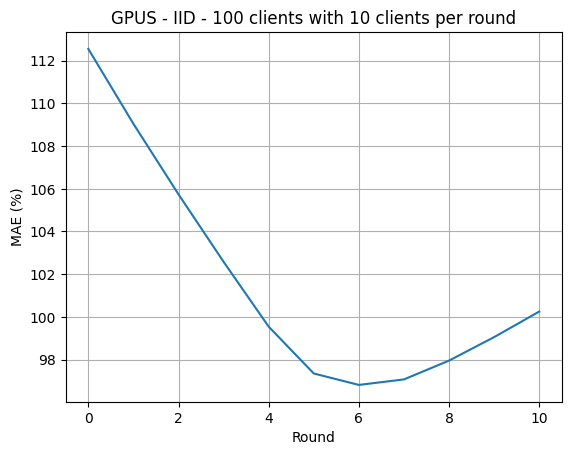

In [133]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_mae_centralised = history.metrics_centralized["mae"]
round = [data[0] for data in global_mae_centralised]
mae = [100.0 * data[1] for data in global_mae_centralised]
plt.plot(round, mae)
plt.grid()
plt.ylabel("MAE (%)")
plt.xlabel("Round")
plt.title("GPUS - IID - 100 clients with 10 clients per round")

Congratulations! With that, you built a Flower client, customized it's instantiation through the `client_fn`, customized the server-side execution through a `FedAvg` strategy configured for this workload, and started a simulation with 100 clients (each holding their own individual partition of the MNIST dataset).

Next, you can continue to explore more advanced Flower topics:

- Deploy server and clients on different machines using `start_server` and `start_client`
- Customize the server-side execution through custom strategies
- Customize the client-side execution through `config` dictionaries

Get all resources you need!

* **[DOCS]** Our complete documenation: https://flower.dev/docs/
* **[Examples]** All Flower examples: https://flower.dev/docs/examples/
* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.dev/join-slack/